In [131]:
import numpy as np

import astropy.units as u  
import astropy.constants as c
import emcee

import matplotlib.pyplot as plt
import matplotlib 
import corner

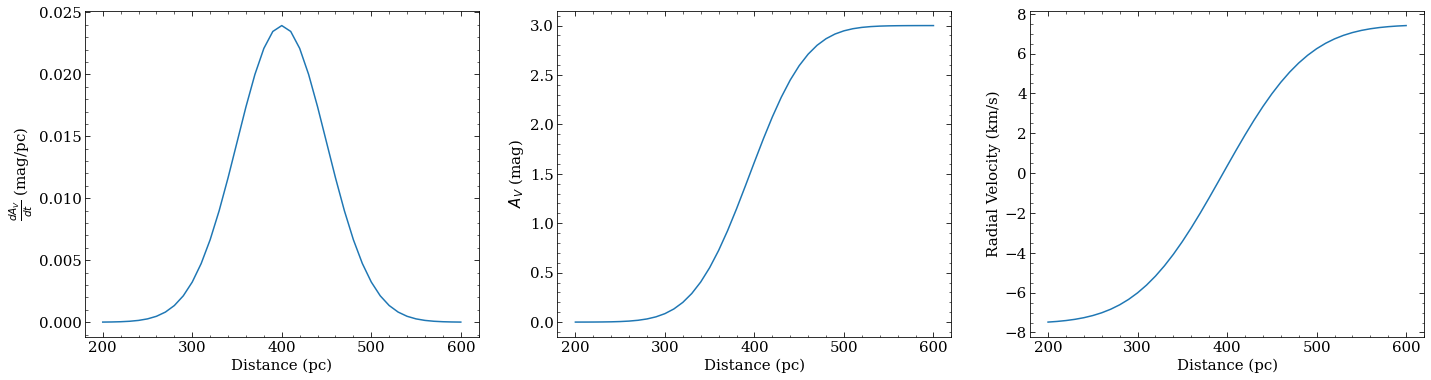

In [132]:
lambda0 = 15272.42 
sigma0 = 2

def dopplershift(v, lambda0 = lambda0):
     return (lambda0 * u.Angstrom * (c.c + v * u.km / u.s) / c.c).to(u.Angstrom).value

### Cloud simulation functions ###

d0 = 400            # Cloud center
w0 = 50             # Cloud width (stdev)
Av_max = 3          # Maximum extinction
vavg = 0            # Average cloud radial velocity
vdiff = 5           # Max velocity offset from vavg


def Differential_Av(d, d0 = d0, w0 = w0, Av_Max = Av_max):
    A = Av_max / (np.sqrt(2 * np.pi) * w0)
    return A * np.exp(-(d - d0)**2 / (2 * w0**2))

def Av(d, **kwargs): 
    dd = d[1]-d[0]
    return np.cumsum(Differential_Av(d, **kwargs)) * dd

def Radial_Velocity(d, d0 = d0, vavg = vavg, vdiff = vdiff):
    dd = d[1]-d[0]
    dispersion = 10 * np.abs(vdiff)
    dv_dd =  1 / (np.sqrt(2 * np.pi) * dispersion)  * np.exp(-(d-d0)**2 / (2 * dispersion**2))
    return 2 * vdiff * np.cumsum(dv_dd) * dd + vavg - vdiff

# vclose = -5
# vfar = 5
# def Radial_Velocity(d, dclose = 200, dfar = 600, vclose = vclose, vfar = vfar):
#     dd = d[1]-d[0]
#     m = (vfar - vclose) / (dfar - dclose)
#     return m * (d - dclose) + vclose


### DIB amplitiude per dAV/dd ###
# From Zasowksi+2015

def Differential_Amplitude(dAv_dd, dd):
     return 1/(np.sqrt(2 * np.pi) * sigma0) * 102e-3 * dAv_dd * dd


### Model cloud visualization ###

distance = np.arange(200, 601, 10)

fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (24, 6))
axs[0].plot(distance, Differential_Av(distance))
axs[0].set_xlabel('Distance (pc)')
axs[0].set_ylabel(r'$\frac{dA_V}{dt}$ (mag/pc)')

axs[1].plot(distance, Av(distance))
axs[1].set_xlabel('Distance (pc)')
axs[1].set_ylabel('$A_V$ (mag)')

axs[2].plot(distance, Radial_Velocity(distance, vdiff = 7.5))

# axs[2].plot(distance, Radial_Velocity(distance, vclose = -7.5, vfar = 7.5) )
axs[2].set_xlabel('Distance (pc)')
axs[2].set_ylabel('Radial Velocity (km/s)')
plt.show()

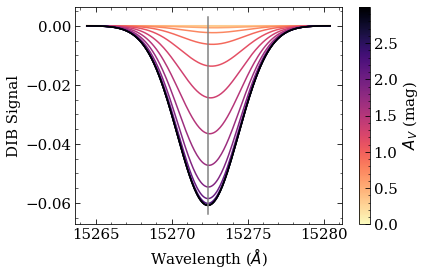

In [133]:
### DIB signal generation ###
spec_res = 200
wavs = np.linspace(lambda0-8, lambda0+8, spec_res)

dd = 25
voxel_dist = np.arange(200, 601, dd)
# star_dist = voxel_dist
voxel_dAv_dd = Differential_Av(voxel_dist)
# star_dAv_dd = voxel_dAv_dd
voxel_rvelo = Radial_Velocity(voxel_dist, vdiff = -7.5)
# voxel_rvelo = Radial_Velocity(voxel_dist, vclose = -7.5, vfar = 7.5)

def make_signals(rvelo, dAv_dd = voxel_dAv_dd, dist = voxel_dist):
    signals = np.zeros((len(dist), spec_res))
    amp = Differential_Amplitude(dAv_dd, dd = dd)

    peak_wavelength = dopplershift(rvelo)
    wavs_grid = np.tile(wavs, (len(dist), 1))
    voxel_DIB_unscaled = np.exp(-(wavs_grid - peak_wavelength[:, np.newaxis])**2 / (2 * sigma0**2))

    def single_signal(dist_max, dist = voxel_dist, amp = amp, sigma0 = sigma0):
        amp = -amp.copy()
        amp[dist > dist_max] = 0
        voxel_DIB_scaled = voxel_DIB_unscaled *  amp[:, np.newaxis] 
        summed_DIB = np.sum(voxel_DIB_scaled, axis = 0)
        return summed_DIB 
    
    for i in range(len(dist)):
        dist_max = dist[i]
        signals[i, :] = single_signal(dist_max)
    return signals

signals = make_signals(voxel_rvelo)


fig, ax = plt.subplots()


normalize = matplotlib.colors.Normalize(0, np.max(np.cumsum(voxel_dAv_dd * dd)))
cmap = matplotlib.cm.magma_r
cmappable = matplotlib.cm.ScalarMappable(norm = normalize, cmap = cmap)
colors = cmap(np.linspace(0,1,len(signals)))

for i in range(len(signals)):
    ax.plot(wavs[:, np.newaxis], signals[i, :], color = colors[i])
ax.plot((lambda0, lambda0), ax.get_ylim(), color = 'grey')
ax.set_xlabel('Wavelength ($\AA$)')
ax.set_ylabel('DIB Signal')
fig.colorbar(cmappable, label = '$A_V$ (mag)')
plt.show()

In [134]:
theoretical_DIB_amp = 102e-3 * np.max(Av(voxel_dist)) / (np.sqrt(2 * np.pi) * sigma0)
print(theoretical_DIB_amp)

0.06103709557510069


In [135]:
SNR = 150

true_signal = make_signals(rvelo = voxel_rvelo)
noisy_signal = true_signal+ np.random.normal(0, 1/SNR, true_signal.shape)


def loglikely(v, snr = SNR, **kwargs):
    return - 0.5 * np.sum((noisy_signal - make_signals(v, **kwargs))**2 / (1/SNR)**2)

def logprior(v):
    if (np.any(np.abs(v) > 12.5)):
        return -np.inf
    return 0.0

def logprob(v, **kwargs):
    lp = logprior(v, **kwargs)
    if not np.isfinite(lp):
        return -np.inf
    return lp + loglikely(v)

In [136]:
nwalkers = 100
ndim = len(voxel_rvelo)
sampler = emcee.EnsembleSampler(100, ndim, logprob)
init =  np.tile(voxel_rvelo, nwalkers).reshape((nwalkers, ndim)) + np.random.normal(0, 1/SNR, (nwalkers, ndim))

In [137]:
sampler.run_mcmc(init, 5000);

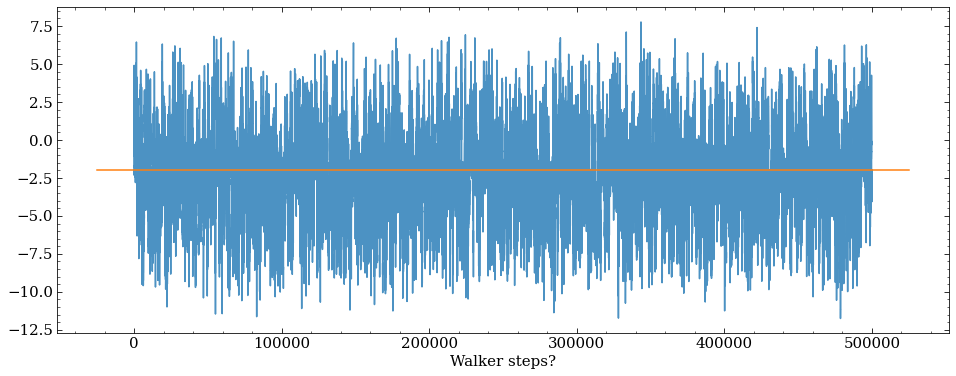

In [ ]:
chain = sampler.chain[:, 0:, :].reshape((-1, len(voxel_rvelo)))
fig, ax  = plt.subplots(figsize = (16, 6))
select = int(len(voxel_rvelo)/2)
ax.plot(chain[:, select], alpha = 0.8)
ax.plot(ax.get_xlim(), (voxel_rvelo[select], voxel_rvelo[select]))
ax.set_xlabel('Walker steps?')
plt.show()


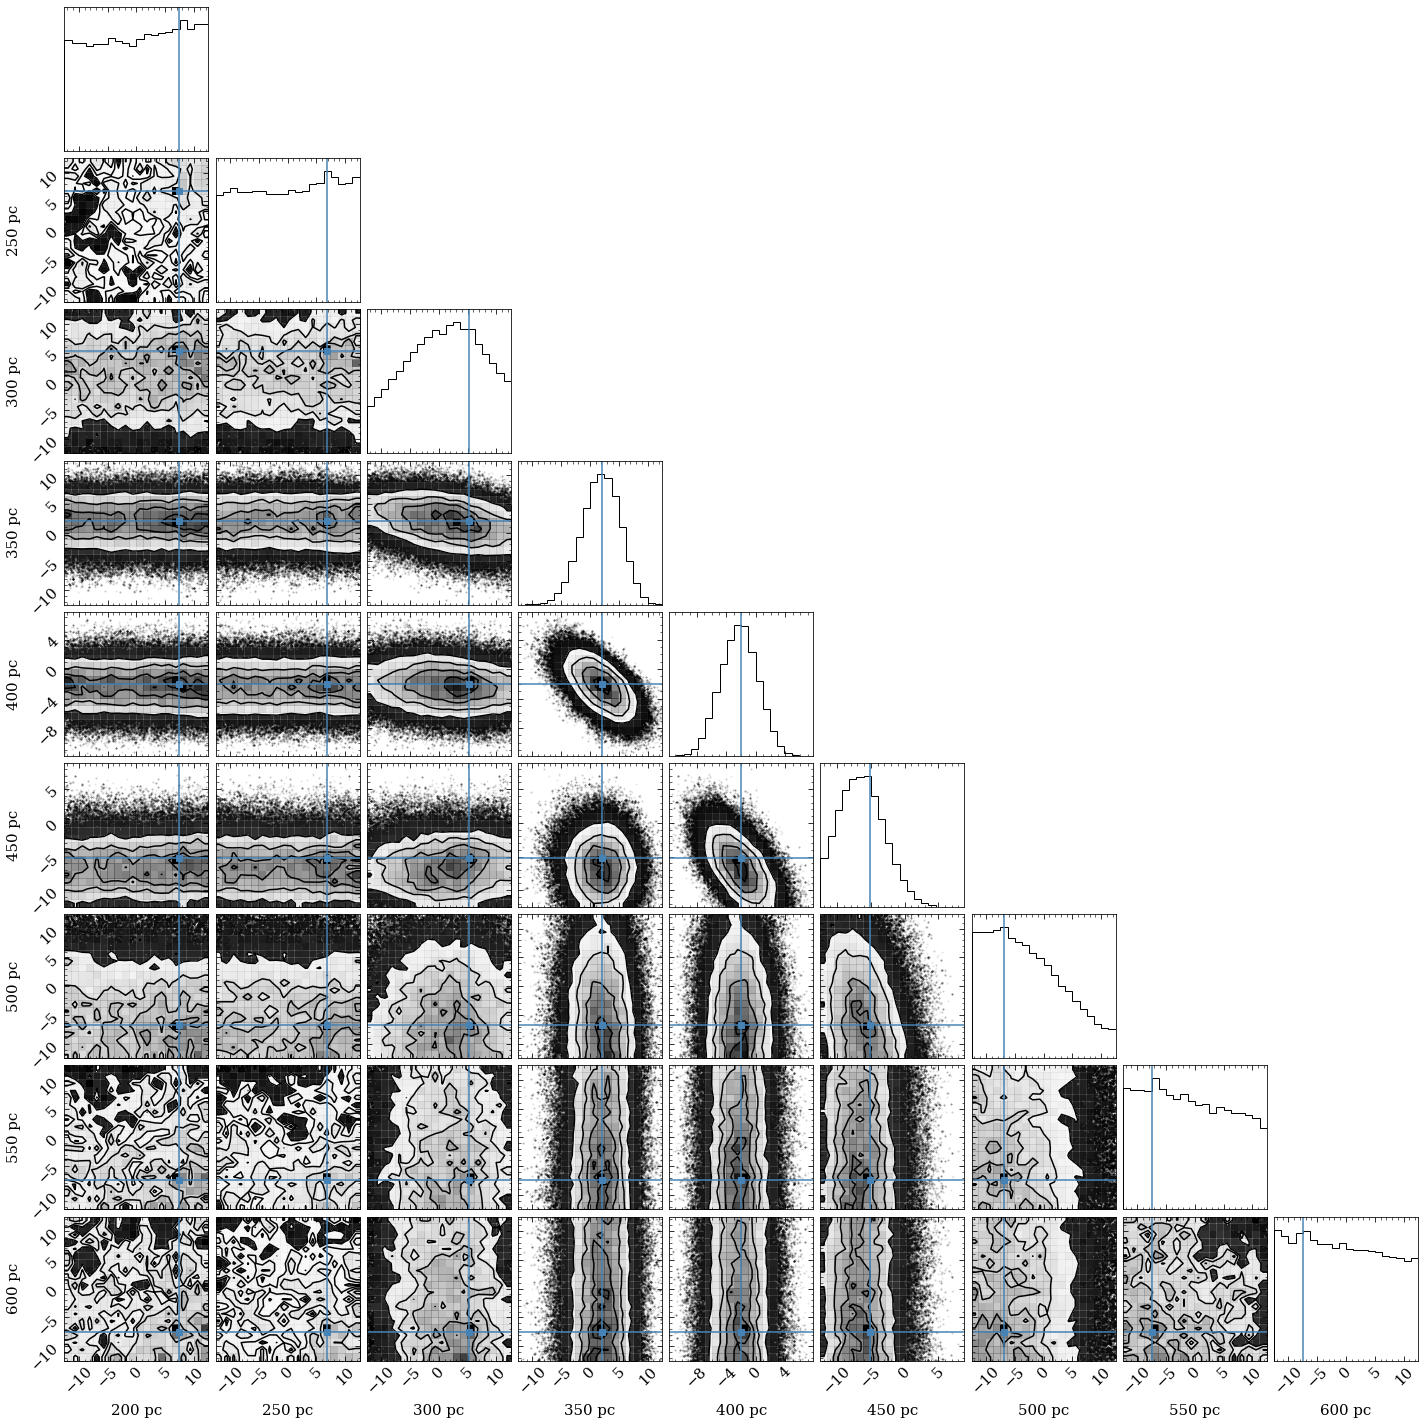

In [ ]:
labels = ['{} pc'.format(i) for i in voxel_dist]
# print(labels)
fig = corner.corner(chain, truths = voxel_rvelo, labels = labels, figsize = (20, 20))
plt.show()

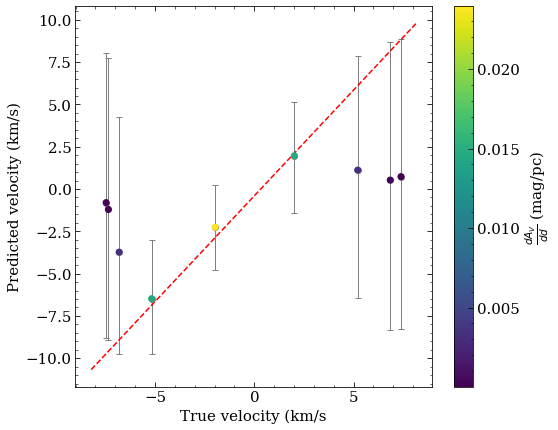

In [ ]:
velocity_mean = np.sum(chain, axis = 0) / chain.shape[0]
velocity_median = np.median(chain, axis = 0)
perc16 = np.percentile(chain,16, axis = 0)
perc84 = np.percentile(chain, 84, axis = 0)
std = np.std(chain, axis = 0, ddof = 1)

fig, ax = plt.subplots(figsize = (8, 7))
# ax.set_aspect('equal')
ax.errorbar(voxel_rvelo, velocity_median, xerr = 1/SNR, yerr = (np.abs(perc16 - velocity_median), np.abs(perc84 - velocity_median)), capsize = 3, fmt = 'o', color = 'grey', linewidth = 1)
# ax.errorbar(voxel_rvelo, velocity_median, xerr = 1/SNR, yerr = std, fmt = 'o', color = 'grey')

points = ax.scatter(voxel_rvelo, velocity_median, c = voxel_dAv_dd, zorder = 3)
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.plot((xmin,xmax), (ymin, ymax), color = 'red', linestyle = 'dashed')

ax.set_xlabel('True velocity (km/s')
ax.set_ylabel('Predicted velocity (km/s)')
fig.colorbar(points, label = r"$\frac{dA_V}{dd}$ (mag/pc)")
plt.show()

In [ ]:
# from dustmaps import BayestarWeb
# from astropy.coordinates import SkyCoord

# l0, b0 = (163., -8.0)
# l = np.arange(l0 - 10., l0 + 10., 0.05)
# b = np.arange(b0 - 10., b0 + 10., 0.05)
# l, b = np.meshgrid(l, b)

# dustcoords = SkyCoord(l*u.deg, b*u.deg,
#                   distance=530.*u.pc, frame='galactic')
# extent = (np.max(dustcoords.l.value), np.min(dustcoords.l.value), np.min(dustcoords.b.value), np.max(dustcoords.b.value))



# bayestar = BayestarWebQuery(version='bayestar2019')
# reddening =  0.302 * bayestar(dustcoords, mode='random_sample').astype(float)